# Using TFIDF Pipeline and Classical Algorithms

In [26]:
pwd

'/run/media/kuldeepsingh/Work/college_stuff/courses/semester_3/cse_482/project'

In [27]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [28]:
# path = "/content/gdrive/My Drive/identify_the_sentiments/"

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.ensemble import VotingClassifier


import warnings
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(style="whitegrid", palette="pastel")

In [4]:
# train = pd.read_csv(path + "data/train_data/train_data.csv")
# test = pd.read_csv(path + "data/test_data/test_data.csv")

train = pd.read_csv("data/train_data.csv")
# test = pd.read_csv("data/test_data.csv")


train.shape, #test.shape

((7920, 10),)

In [5]:
train.head()

,id,label,tweet,topics,num_topics,extracted_emojis,num_emojis,length_of_tweet,num_of_slurrs,emoji_score
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy android apps beautiful c...,11.0,noemoji,0.0,13,0.0,0
1,2,0,Finally a transparant silicon case ^^ Thanks t...,yay sony xperia s sonyexperias…,5.0,:),1.0,17,0.0,2
2,3,0,We love this! Would you go? #talk #makememorie...,talk makememories unplug relax iphone smartpho...,8.0,noemoji,0.0,15,0.0,0
3,4,0,I'm wired I know I'm George I was made that wa...,iphone cute daventry home,4.0,;),1.0,17,0.0,0
4,5,1,What amazing service! Apple won't even talk to...,no_topics,0.0,noemoji,0.0,23,0.0,0


In [6]:
train.isnull().sum()

id                  0
label               0
tweet               0
topics              0
num_topics          0
extracted_emojis    0
num_emojis          0
length_of_tweet     0
num_of_slurrs       0
emoji_score         0
dtype: int64

In [7]:
# emoji_dict = {}
# for s in train.emoji:
#     if type(s) == str:
#         emojis = s.split()
#         for e in emojis:
#             if e not in emoji_dict.keys():
#                 emoji_dict[e] = 0
#             else:
#                 emoji_dict[e] += 1

# emoji_dict

In [8]:
def preprocess_tweet(tweet):
    #convert the tweet to lower case
    tweet = tweet.lower()
    
    #convert all urls to sting "URL"
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    
    #convert all @username to "AT_USER"
    tweet = re.sub('@[^\s]+','username', tweet)
    
    # coverting "$&@*#" to slur
    tweet = re.sub('$&@*#','profane', tweet)

    #correct all multiple white spaces to a single white space
    tweet = re.sub('[\s]+', ' ', tweet)
    
    #convert "#topic" to just "topic"
    # tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = re.sub(r'#([^\s]+)', r' ', tweet)
    
    #correct all multiple white spaces to a single white space
    tweet = re.sub('[\s]+', ' ', tweet)

    return tweet.lower().strip()


def extract_topics(tweet):
    pattern = re.compile(r'#([^\s]+)')
    matches = pattern.findall(tweet)
    topic_string = " ".join(list(set(matches)))
    if len(topic_string) < 1:
        topic_string = "no_topics"
    return topic_string.lower().strip()

def num_topics(tweet):
    pattern = re.compile(r'#([^\s]+)')
    matches = pattern.findall(tweet)
    topic_string = " ".join(matches)
    return float(len(topic_string.split()))


def extract_emojis(tweet):
    pattern = re.compile(r"(?::|;|=)(?:-)?(?:\)|\(|D|P)")
    matches = pattern.findall(tweet)
    emoji_string = " ".join(matches)
    if len(emoji_string) < 1:
        emoji_string = "noemoji"
    return emoji_string.lower().strip()

def num_emojis(string):
    pattern = re.compile(r"(?::|;|=)(?:-)?(?:\)|\(|D|P)")
    matches = pattern.findall(string)
    emoji_string = " ".join(matches)
    return float(len(emoji_string.split()))

def emoji_tokenizer(text):
    return text.strip().split()


# length of tweet
def length_of_tweet(text):
    return len(text.lower().strip().split())

# num of slurrs
def num_of_slurrs(text):
    num_of_slurrs = float(text.count("$&@*#")) + float(text.count("fuck")) + float(text.count("crap"))
    return num_of_slurrs


# emoji score 
def get_emoji_score(tweet):
    emoji_type_dict = {
        "noemoji": 0,
        ':(': -2,
        ':)': 2,
        ':-(': -2,
        ':-)': 2,
        ':-D': 2,
        ':D': 2,
        ':P': -1,
        ';)': 0,
        ';-)': 0,
        ';D': 0,
        '=(': -2,
        '=)': 2,
        '=D': 2,
        '=P': 0,
        ':-P': -1
    }
    
    pattern = re.compile(r"(?::|;|=)(?:-)?(?:\)|\(|D|P)")
    matches = pattern.findall(tweet)
    emoji_string = " ".join(matches)
    if len(emoji_string) < 1:
        emoji_string = "noemoji"
    score_list = [emoji_type_dict[e] for e in emoji_string.split()]
    return sum(score_list)

In [9]:
train["topics"] = train.tweet.apply(extract_topics)
train["num_topics"] = train.tweet.apply(num_topics)
train["extracted_emojis"] = train.tweet.apply(extract_emojis)
train["num_emojis"] = train.tweet.apply(num_emojis)
train["length_of_tweet"] = train.tweet.apply(length_of_tweet)
train["num_of_slurrs"] = train.tweet.apply(num_of_slurrs)
train["emoji_score"] = train.tweet.apply(get_emoji_score)
train["tweet_preprocessed"] = train.tweet.apply(preprocess_tweet)



# test["topics"] = test.tweet.apply(extract_topics)
# test["num_topics"] = test.tweet.apply(num_topics)
# test["extracted_emojis"] = test.tweet.apply(extract_emojis)
# test["num_emojis"] = test.tweet.apply(num_emojis)
# test["length_of_tweet"] = test.tweet.apply(length_of_tweet)
# test["num_of_slurrs"] = test.tweet.apply(num_of_slurrs)
# test["emoji_score"] = test.tweet.apply(get_emoji_score)

In [10]:
train.head()

,id,label,tweet,topics,num_topics,extracted_emojis,num_emojis,length_of_tweet,num_of_slurrs,emoji_score,tweet_preprocessed
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,android iphone iphonesia cute iphoneonly apps ...,11.0,noemoji,0.0,13,0.0,0,test url
1,2,0,Finally a transparant silicon case ^^ Thanks t...,yay sony xperia s sonyexperias…,5.0,:),1.0,17,0.0,2,finally a transparant silicon case ^^ thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...,iphone smartphone relax unplug makememories wi...,8.0,noemoji,0.0,15,0.0,0,we love this! would you go? url
3,4,0,I'm wired I know I'm George I was made that wa...,iphone home cute daventry,4.0,;),1.0,17,0.0,0,i'm wired i know i'm george i was made that wa...
4,5,1,What amazing service! Apple won't even talk to...,no_topics,0.0,noemoji,0.0,23,0.0,0,what amazing service! apple won't even talk to...


In [11]:
train.label.value_counts()

0    5894
1    2026
Name: label, dtype: int64

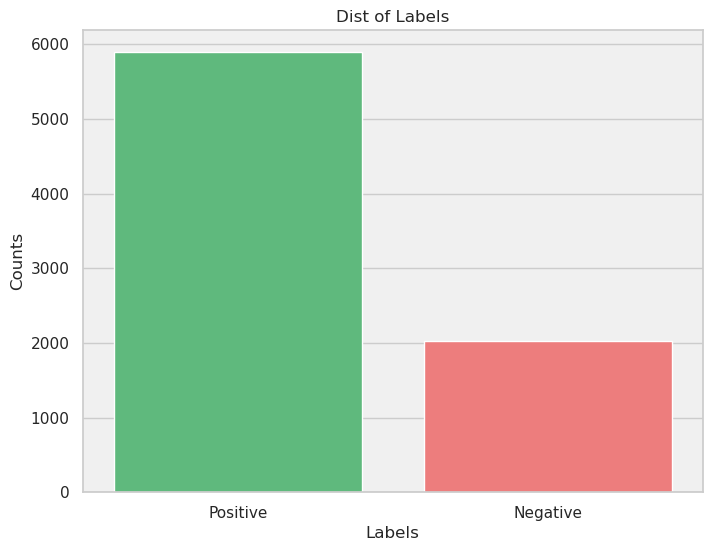

In [40]:
categories = ['Positive', 'Negative']
values = [5894, 2026]

# Create a figure and axis
plt.figure(figsize=(8, 6))

custom_palette = {"Positive": "#50C878", "Negative": "#FF6B6B"}

# Create the bar chart
sns.barplot(x=categories, y=values, palette=custom_palette)

# Customize the appearance
plt.title('Dist of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade
plt.show()

In [41]:
train.loc[train.label == 0, 'label'] = "Positive"
train.loc[train.label == 1, 'label'] = "Negative"
train.label.value_counts()

Positive    5894
Negative    2026
Name: label, dtype: int64

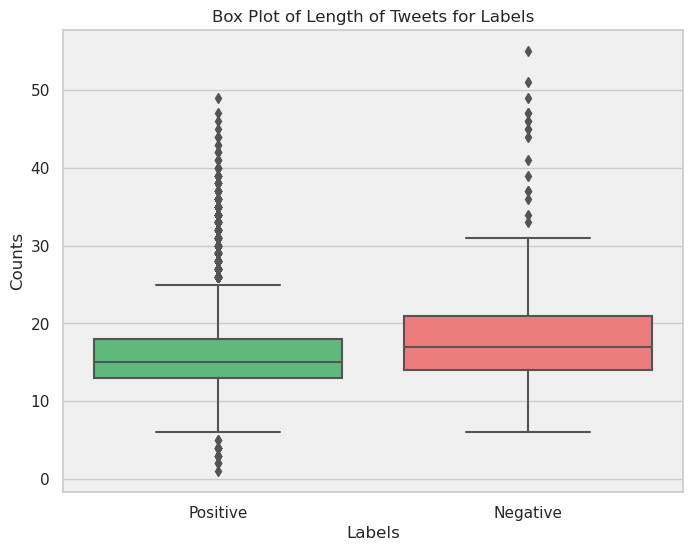

In [42]:
# Create a sample DataFrame (replace this with your actual DataFrame)

# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size

sns.set(style="whitegrid")  # Set the style

custom_palette = {"Positive": "#50C878", "Negative": "#FF6B6B"}
sns.boxplot(x='label', y='length_of_tweet', data=train, palette=custom_palette)  # Create the box plot with Seaborn

plt.title('Box Plot of Length of Tweets for Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade
plt.show()  # Display the plot

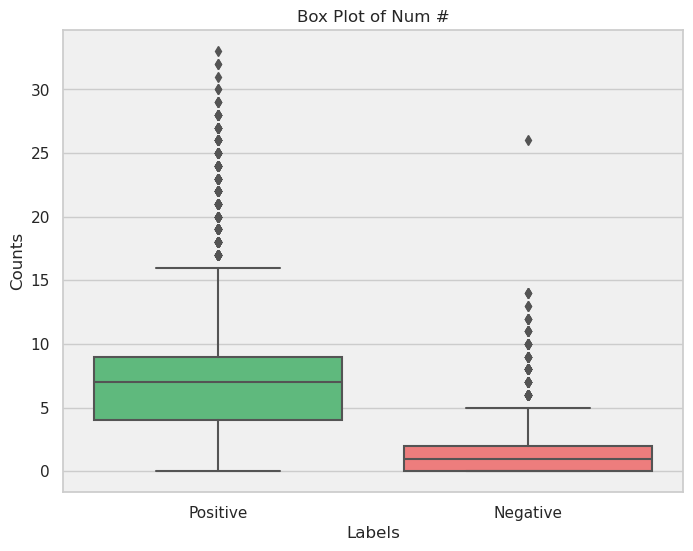

In [43]:
# Create a sample DataFrame (replace this with your actual DataFrame)

# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size

sns.set(style="whitegrid")  # Set the style

custom_palette = {"Positive": "#50C878", "Negative": "#FF6B6B"}
sns.boxplot(x='label', y='num_topics', data=train, palette=custom_palette)  # Create the box plot with Seaborn

plt.title('Box Plot of Num #')
plt.xlabel('Labels')
plt.ylabel('Counts')
# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade
plt.show()  # Display the plot

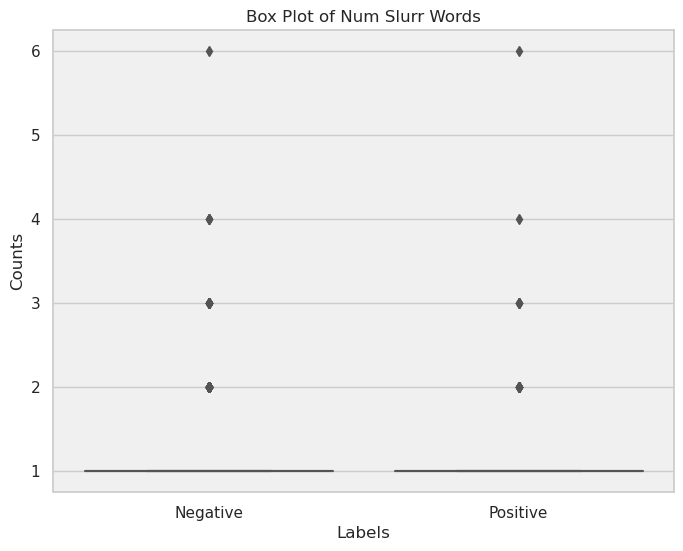

In [44]:
# Create a sample DataFrame (replace this with your actual DataFrame)

# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size

sns.set(style="whitegrid")  # Set the style

custom_palette = {"Positive": "#50C878", "Negative": "#FF6B6B"}
sns.boxplot(x='label', y='num_of_slurrs', data=train[train.num_of_slurrs > 0], palette=custom_palette)  # Create the box plot with Seaborn

plt.title('Box Plot of Num Slurr Words')
plt.xlabel('Labels')
plt.ylabel('Counts')
# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade
plt.show()  # Display the plot

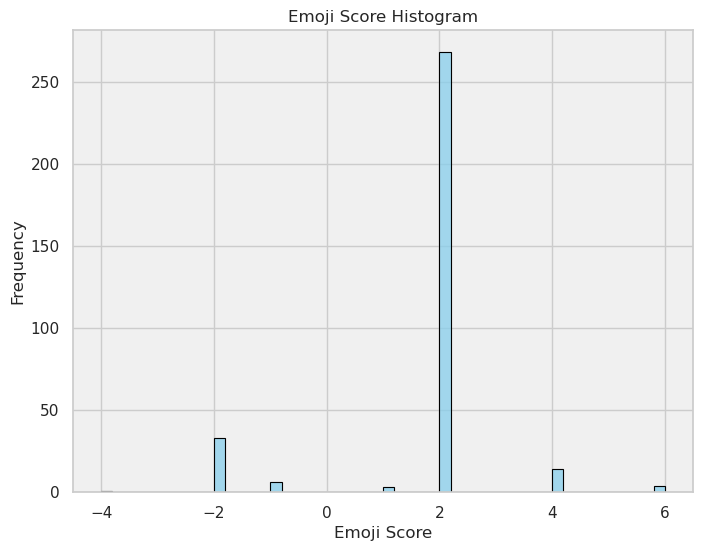

In [46]:
# train.emoji_score.hist()

plt.figure(figsize=(8, 6))

sns.histplot(train[train.emoji_score != 0].emoji_score, bins=50, color='skyblue', edgecolor='black')

# Customize the appearance
plt.title('Emoji Score Histogram')
plt.xlabel('Emoji Score')
plt.ylabel('Frequency')

# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade

plt.show()

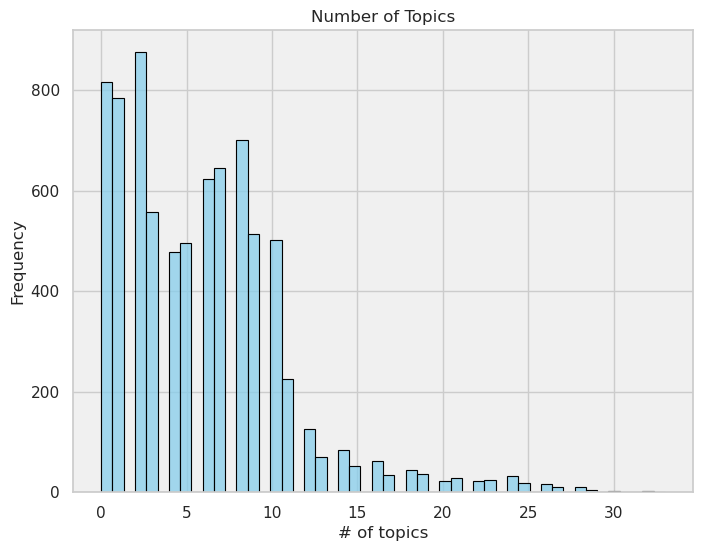

In [47]:
# train.num_topics.hist()
plt.figure(figsize=(8, 6))

sns.histplot(train.num_topics, bins=50, color='skyblue', edgecolor='black')

# Customize the appearance
plt.title('Number of Topics')
plt.xlabel('# of topics')
plt.ylabel('Frequency')

# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade

plt.show()

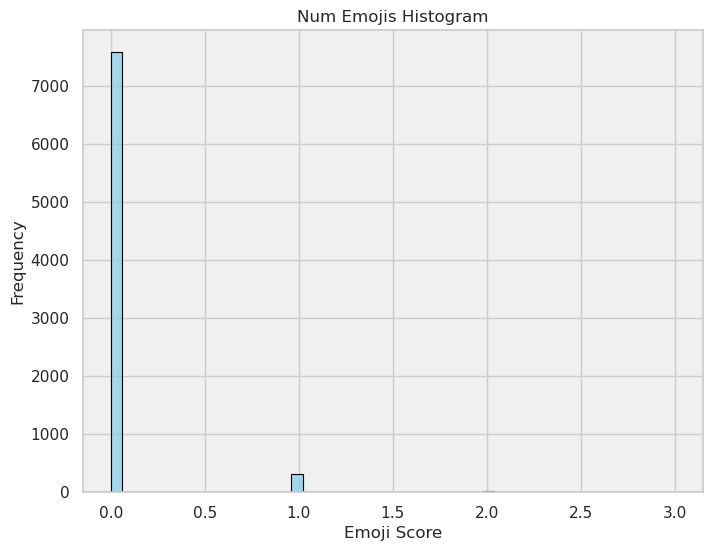

In [48]:
# train.num_emojis.hist()

plt.figure(figsize=(8, 6))

sns.histplot(train.num_emojis, bins=50, color='skyblue', edgecolor='black')

# Customize the appearance
plt.title('Num Emojis Histogram')
plt.xlabel('Emoji Score')
plt.ylabel('Frequency')

# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade

plt.show()

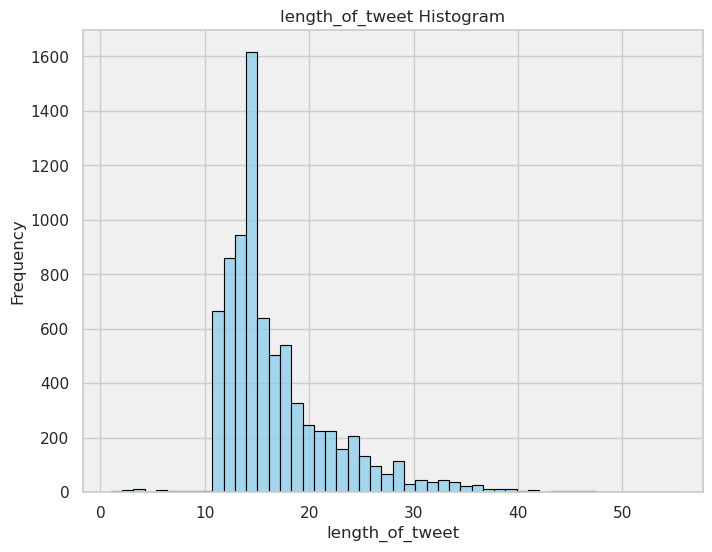

In [49]:
# train.length_of_tweet.hist()
plt.figure(figsize=(8, 6))

sns.histplot(train.length_of_tweet, bins=50, color='skyblue', edgecolor='black')

# Customize the appearance
plt.title('length_of_tweet Histogram')
plt.xlabel('length_of_tweet')
plt.ylabel('Frequency')

# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade

plt.show()

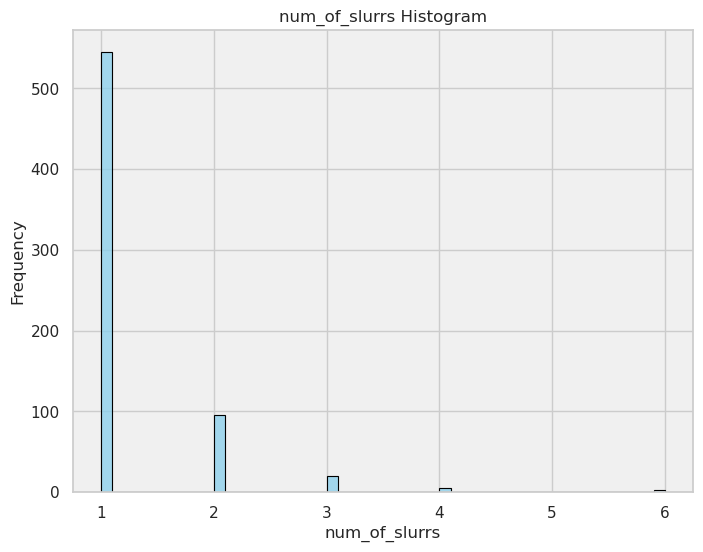

In [50]:
# train.num_of_slurrs.hist()
plt.figure(figsize=(8, 6))

sns.histplot(train[train.num_of_slurrs > 0].num_of_slurrs, bins=50, color='skyblue', edgecolor='black')

# Customize the appearance
plt.title('num_of_slurrs Histogram')
plt.xlabel('num_of_slurrs')
plt.ylabel('Frequency')

# Set the background color to off-white
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Change the color code to your desired off-white shade

plt.show()

In [ ]:
# ' '.join([w.lower() for item in train[(train.label == 'Negative')].topics.tolist() for w in item.split()])

In [12]:
train.head()

,id,label,tweet,topics,num_topics,extracted_emojis,num_emojis,length_of_tweet,num_of_slurrs,emoji_score,tweet_preprocessed
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,android iphone iphonesia cute iphoneonly apps ...,11.0,noemoji,0.0,13,0.0,0,test url
1,2,0,Finally a transparant silicon case ^^ Thanks t...,yay sony xperia s sonyexperias…,5.0,:),1.0,17,0.0,2,finally a transparant silicon case ^^ thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...,iphone smartphone relax unplug makememories wi...,8.0,noemoji,0.0,15,0.0,0,we love this! would you go? url
3,4,0,I'm wired I know I'm George I was made that wa...,iphone home cute daventry,4.0,;),1.0,17,0.0,0,i'm wired i know i'm george i was made that wa...
4,5,1,What amazing service! Apple won't even talk to...,no_topics,0.0,noemoji,0.0,23,0.0,0,what amazing service! apple won't even talk to...


In [15]:
# numerical features
numeric_features = ["num_topics", "num_emojis", "length_of_tweet", 'num_of_slurrs', 'emoji_score']
numeric_transformer = Pipeline(
    [
        ("scaler", StandardScaler())
    ]
)


# categorical features
categorical_features = []
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")


# text features
text_features = ['tweet_preprocessed', 'topics', 'extracted_emojis']
text_transformer = FeatureUnion(
    [
        (
            'tweet_tfidf',
            Pipeline(
                [
                    (
                        'extract_field',
                        FunctionTransformer(lambda x: x['tweet_preprocessed'], validate=False)
                    ),
                    (
                        'tfidf',
                        TfidfVectorizer()
                    )
                ]
            )
        ),
        (
            'topic_tfidf',
            Pipeline(
                [
                    (
                        'extract_field',
                        FunctionTransformer(lambda x: x['topics'], validate=False)
                    ),
                    (
                        'tfidf',
                        TfidfVectorizer()
                    )
                ]
            )
        ),
        (
            'emoji_tfidf',
            Pipeline(
                [
                    (
                        'extract_field',
                        FunctionTransformer(lambda x: x['extracted_emojis'], validate=False)
                    ),
                    (
                        'tfidf',
                        TfidfVectorizer()
                    )
                ]
            )
        )
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("text", text_transformer, text_features),
    ]
)

# For Logistic Regression

In [17]:
ppl_logistic = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

parameters = {
    # tweet text features
    "preprocessor__text__tweet_tfidf__tfidf__ngram_range": [(1, 2)],
    # "preprocessor__text__tweet_tfidf__tfidf__min_df": [5],
    # "preprocessor__text__tweet_tfidf__tfidf__max_df": [0.90],
    
    # topic text features
    "preprocessor__text__topic_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__topic_tfidf__tfidf__min_df": [2],
    # "preprocessor__text__topic_tfidf__tfidf__max_df": [0.90],
    
    # emoji text features
    "preprocessor__text__emoji_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__emoji_tfidf__tfidf__min_df": [1],
    # "preprocessor__text__emoji_tfidf__tfidf__max_df": [0.90],

    # classifier features
    "classifier__C": [1],
    # "classifier__kernel": ["linear"],
    # "classifier__C": [1],
    # 'classifier__random_forest__n_estimators': [100],
    # 'classifier__knn__n_neighbors': [5]

}

# train the classifier
clf = GridSearchCV(ppl_logistic, parameters, cv=10, scoring="f1")
clf.fit(train, train["label"])

print("Gridsearch score is {}".format(clf.best_score_))
print(clf.best_params_)

Gridsearch score is 0.8016483134280918
{'classifier__C': 1, 'preprocessor__text__emoji_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__topic_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__tweet_tfidf__tfidf__ngram_range': (1, 2)}


# For SVM

In [18]:
ppl_svm = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

parameters = {
    # tweet text features
    "preprocessor__text__tweet_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__tweet_tfidf__tfidf__min_df": [5],
    # "preprocessor__text__tweet_tfidf__tfidf__max_df": [0.90],
    
    # topic text features
    "preprocessor__text__topic_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__topic_tfidf__tfidf__min_df": [2],
    # "preprocessor__text__topic_tfidf__tfidf__max_df": [0.90],
    
    # emoji text features
    "preprocessor__text__emoji_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__emoji_tfidf__tfidf__min_df": [1],
    # "preprocessor__text__emoji_tfidf__tfidf__max_df": [0.90],

    # classifier features
    # "classifier__C": [1],
    "classifier__kernel": ["linear"],
    "classifier__C": [1],
    # 'classifier__random_forest__n_estimators': [100],
    # 'classifier__knn__n_neighbors': [5]

}

# train the classifier
clf = GridSearchCV(ppl_svm, parameters, cv=10, scoring="f1")
clf.fit(train, train["label"])

print("Gridsearch score is {}".format(clf.best_score_))
print(clf.best_params_)

Gridsearch score is 0.8154707704817479
{'classifier__C': 1, 'classifier__kernel': 'linear', 'preprocessor__text__emoji_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__topic_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__tweet_tfidf__tfidf__ngram_range': (1, 1)}


# For Random Forest

In [19]:
ppl_random_Forest = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

parameters = {
    # tweet text features
    "preprocessor__text__tweet_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__tweet_tfidf__tfidf__min_df": [5],
    # "preprocessor__text__tweet_tfidf__tfidf__max_df": [0.90],
    
    # topic text features
    "preprocessor__text__topic_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__topic_tfidf__tfidf__min_df": [2],
    # "preprocessor__text__topic_tfidf__tfidf__max_df": [0.90],
    
    # emoji text features
    "preprocessor__text__emoji_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__emoji_tfidf__tfidf__min_df": [1],
    # "preprocessor__text__emoji_tfidf__tfidf__max_df": [0.90],

    # classifier features
    # "classifier__C": [1],
    # "classifier__kernel": ["linear"],
    # "classifier__C": [1],
    'classifier__n_estimators': [100],
    # 'classifier__knn__n_neighbors': [5]

}

# train the classifier
clf = GridSearchCV(ppl_random_Forest, parameters, cv=10, scoring="f1")
clf.fit(train, train["label"])

print("Gridsearch score is {}".format(clf.best_score_))
print(clf.best_params_)

Gridsearch score is 0.791755568674325
{'classifier__n_estimators': 100, 'preprocessor__text__emoji_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__topic_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__tweet_tfidf__tfidf__ngram_range': (1, 1)}


# For KNN

In [20]:
ppl_knn = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

parameters = {
    # tweet text features
    "preprocessor__text__tweet_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__tweet_tfidf__tfidf__min_df": [5],
    # "preprocessor__text__tweet_tfidf__tfidf__max_df": [0.90],
    
    # topic text features
    "preprocessor__text__topic_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__topic_tfidf__tfidf__min_df": [2],
    # "preprocessor__text__topic_tfidf__tfidf__max_df": [0.90],
    
    # emoji text features
    "preprocessor__text__emoji_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__emoji_tfidf__tfidf__min_df": [1],
    # "preprocessor__text__emoji_tfidf__tfidf__max_df": [0.90],

    # classifier features
    # "classifier__C": [1],
    # "classifier__kernel": ["linear"],
    # "classifier__C": [1],
    # 'classifier__n_estimators': [100],
    'classifier__n_neighbors': [5]

}

# train the classifier
clf = GridSearchCV(ppl_knn, parameters, cv=10, scoring="f1")
clf.fit(train, train["label"])

print("Gridsearch score is {}".format(clf.best_score_))
print(clf.best_params_)

Gridsearch score is 0.7717332324324668
{'classifier__n_neighbors': 5, 'preprocessor__text__emoji_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__topic_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__tweet_tfidf__tfidf__ngram_range': (1, 1)}


# For AdaBoostClassifier

In [22]:
ppl_ada = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", AdaBoostClassifier())]
)

parameters = {
    # tweet text features
    "preprocessor__text__tweet_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__tweet_tfidf__tfidf__min_df": [5],
    # "preprocessor__text__tweet_tfidf__tfidf__max_df": [0.90],
    
    # topic text features
    "preprocessor__text__topic_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__topic_tfidf__tfidf__min_df": [2],
    # "preprocessor__text__topic_tfidf__tfidf__max_df": [0.90],
    
    # emoji text features
    "preprocessor__text__emoji_tfidf__tfidf__ngram_range": [(1, 1)],
    # "preprocessor__text__emoji_tfidf__tfidf__min_df": [1],
    # "preprocessor__text__emoji_tfidf__tfidf__max_df": [0.90],

    # classifier features
    # "classifier__C": [1],
    # "classifier__kernel": ["linear"],
    # "classifier__C": [1],
    'classifier__n_estimators': [100],
    # 'classifier__n_neighbors': [5]

}

# train the classifier
clf = GridSearchCV(ppl_ada, parameters, cv=10, scoring="f1")
clf.fit(train, train["label"])

print("Gridsearch score is {}".format(clf.best_score_))
print(clf.best_params_)

Gridsearch score is 0.7845636754338761
{'classifier__n_estimators': 100, 'preprocessor__text__emoji_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__topic_tfidf__tfidf__ngram_range': (1, 1), 'preprocessor__text__tweet_tfidf__tfidf__ngram_range': (1, 1)}


In [15]:
from sklearn.utils import estimator_html_repr

with open("pipeline_image_svm.html", "w") as f:
    f.write(estimator_html_repr(ppl_svm))

In [103]:
def create_df(text):
    df = pd.DataFrame()
    df['tweet'] = [text]
    df["topics"] = df.tweet.apply(extract_topics)
    df["num_topics"] = df.tweet.apply(num_topics)
    df["extracted_emojis"] = df.tweet.apply(extract_emojis)
    df["num_emojis"] = df.tweet.apply(num_emojis)
    df["length_of_tweet"] = df.tweet.apply(length_of_tweet)
    df["num_of_slurrs"] = df.tweet.apply(num_of_slurrs)
    df["emoji_score"] = df.tweet.apply(get_emoji_score)
    df['tweet'] = df.tweet.apply(preprocess_tweet)
    return df

In [104]:
df = create_df('I am feeling good today')
df.head()

,tweet,topics,num_topics,extracted_emojis,num_emojis,length_of_tweet,num_of_slurrs,emoji_score
0,i am feeling good today,no_topics,0.0,noemoji,0.0,5,0.0,0
